In [2]:
import os
import argparse
import time
import glob
import pickle
import subprocess
import shlex
import io
import pprint
import importlib
from urllib.request import urlopen
from IPython.display import Image as dispImg
import scipy.io
import numpy as np
import pandas
import tqdm
import fire
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.model_zoo
import torchvision
from art.classifiers import PyTorchClassifier
import cornet
from art.attacks import BoundaryAttack
from art.attacks import HopSkipJump
from imgaug import augmenters as iaa
import imgaug as ia
#attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
from art.attacks import FastGradientMethod
from art.attacks import ProjectedGradientDescent

from PIL import Image
Image.warnings.simplefilter('ignore')

ia.seed(1)
np.random.seed(0)
torch.manual_seed(0)

mean = torch.tensor([0.44, 0.44, 0.44], dtype=torch.float32)
std = torch.tensor([0.225, 0.225, 0.225], dtype=torch.float32)
normalize = torchvision.transforms.Normalize(mean=[0.44, 0.44, 0.44],
                                             std=[0.225, 0.225, 0.225])
transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(256),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                normalize
            ])
unnormalize = torchvision.transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def get_model(model_size='z', cuda=False):
    map_location = 'cpu' if not cuda else None
    #map_location = None
    model = getattr(cornet, f'cornet_{model_size.lower()}')
    if model_size.lower() == 'r':
        model = model(pretrained=True, map_location=map_location, times=5)
    else:
        model = model(pretrained=True, map_location=map_location)
    if cuda:
        model = model.cuda()
        return model
    model.cpu()
    return model.module

sharpen = iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5), deterministic=True)


                # Same as sharpen, but for an embossing effect.
emboss = iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0), deterministic=True)


Load data

In [7]:
labels = pickle.load(open("labels.pkl", "rb" ))
y_val = np.load("D:\\imagenet2012\\y_val.npy")
print(f"{y_val.shape[0]} validation labels loaded")
data_path = 'D:\\imagenet2012\\val'
fnames = sorted(glob.glob(os.path.join(data_path, '*.*')))
print(f"{len(fnames)} files found");

50000 validation labels loaded
50000 files found


In [3]:
def to_grayscale(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

In [4]:
def get_image_by_class(image_class):
    return Image.open(fnames[np.argsort((y_val == image_class))[-1]]).convert('RGB')

In [5]:
def plot_augmented(original_image, adv_image):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
    axes[0, 0].imshow(to_grayscale(original_image))
    axes[0, 1].imshow(to_grayscale(adv_image))
    axes[1, 0].imshow(to_grayscale(sharpen.augment_image(original_image)))
    axes[1, 1].imshow(to_grayscale(sharpen.augment_image(adv_image)))
    axes[2, 0].imshow(to_grayscale(emboss.augment_image(original_image)))
    axes[2, 1].imshow(to_grayscale(emboss.augment_image(adv_image)))
    plt.show()

In [6]:
def perform_attack(im, model_size, target_class=None, targeted=False, params={}):
    model = get_model(model_size)
    model.eval()
    print(f'using model type: {model_size}')
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


    classifier = PyTorchClassifier(model=model, loss=criterion,
                               optimizer=optimizer, nb_classes=1000, input_shape=(3,224,224), clip_values=(-1.956, 6.4))
    attack = ProjectedGradientDescent(classifier=classifier, targeted=targeted, **params)
    
    x = transform(im).unsqueeze(0).numpy()
    
    pred = classifier.predict(x)[0]
    pred = np.exp(pred)/sum(np.exp(pred))
    top_5 = np.flip(np.argsort(pred)[-5:])
    print('\nOriginal image predictions:')
    for t in top_5:
        print(f'{labels[t]} ({t}): {pred[t]}')
    print('\nGenerating adversarial example')
    x_adv = attack.generate(x=transform(im).unsqueeze(0).numpy(), y=np.array([target_class]) if target_class is not None else None)
    print('L2: ' + str(np.linalg.norm(np.reshape(x_adv[0] - x[0], [-1]))))
    
    original_image = np.moveaxis(unnormalize(torch.from_numpy(x[0])).numpy(),  [0, 1, 2], [2, 0, 1])
    adv_image = np.moveaxis(unnormalize(torch.from_numpy(x_adv[0])).numpy(),  [0, 1, 2], [2, 0, 1])
    pert = np.abs(adv_image - original_image)[..., ::-1]
    pert_min = np.min(pert)
    pert_max = np.max(pert)
    pert_image = -((pert - pert_min) / (pert_max - pert_min))+1

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
    axes[0].imshow(original_image)
    axes[1].imshow(pert_image)
    axes[2].imshow(adv_image)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
    axes[0].imshow(to_grayscale(original_image))
    axes[1].imshow(to_grayscale(adv_image))
    
    adv_pred = classifier.predict(x_adv)[0]
    adv_pred = np.exp(adv_pred)/sum(np.exp(adv_pred))
    top_5 = np.flip(np.argsort(adv_pred)[-5:])
    print('\nAdversarial image predictions:')
    for t in top_5:
        print(f'{labels[t]} ({t}): {adv_pred[t]}')
    
    plt.show()

In [7]:
i=39218
print(labels[y_val[i]])
#target 39206

magpie


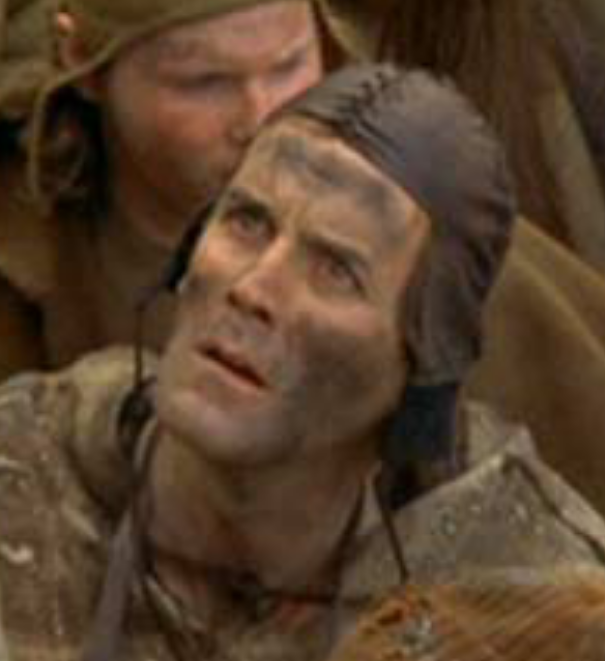

In [8]:
#im = Image.open(fnames[i]).convert('RGB')
#im = Image.open("D:\\imagenet2012\junco.jpg").convert('RGB')
im = Image.open("D:\\imagenet2012\john_cleese.png").convert('RGB')
#im = Image.open(fnames[np.argsort((y_val == 26))[-3]]).convert('RGB')
im

In [22]:
def get_classifier(model_size='z'):
    model = get_model(model_size)
    model.eval()
    print(f'using model type: {model_size}')

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


    classifier = PyTorchClassifier(model=model, loss=criterion,
                                   optimizer=optimizer, nb_classes=1000, input_shape=(3,224,224), clip_values=(-1.956, 6.4))
    return classifier

In [23]:
z = get_classifier()
s = get_classifier('s')
    


using model type: z
using model type: s


In [30]:
def predict(classifier, photo, show_pic=True):
    im = Image.open(f"C:\\Users\\serge\\Pictures\\106_PANA\\{photo}.jpg").convert('RGB')

    x = transform(im).unsqueeze(0).numpy()

    pred = classifier.predict(x)[0]
    pred = np.exp(pred)/sum(np.exp(pred))
    top_5 = np.flip(np.argsort(pred)[-5:])
    print('\nOriginal image predictions:')
    for t in top_5:
        print(f'{labels[t]} ({t}): {pred[t]}')
    if show_pic:
        plt.imshow(np.moveaxis(unnormalize(torch.from_numpy(x[0])).numpy(),  [0, 1, 2], [2, 0, 1]))
        plt.show()


Original image predictions:
white stork, Ciconia ciconia (127): 0.9783768057823181
black stork, Ciconia nigra (128): 0.016757436096668243
crane (134): 0.0014345271047204733
spoonbill (129): 0.0011961223790422082
bustard (138): 0.000374634750187397


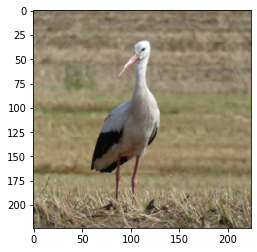

In [25]:
photo = 'P1060444'
predict(s, photo)


Original image predictions:
pelican (144): 0.07789785414934158
brown bear, bruin, Ursus arctos (294): 0.07045508921146393
Border terrier (182): 0.0628945603966713
mink (357): 0.05706492438912392
goose (99): 0.04809406027197838

Original image predictions:
dowitcher (142): 0.3216538429260254
little blue heron, Egretta caerulea (131): 0.10997665673494339
red-backed sandpiper, dunlin, Erolia alpina (140): 0.10671905428171158
pelican (144): 0.08084506541490555
spoonbill (129): 0.053981173783540726


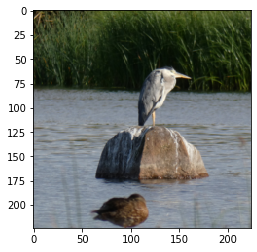

In [31]:
predict(z, 'P1060352', False)
predict(s, 'P1060352')


Original image predictions:
red-backed sandpiper, dunlin, Erolia alpina (140): 0.31080520153045654
redshank, Tringa totanus (141): 0.17577819526195526
dowitcher (142): 0.14939869940280914
American coot, marsh hen, mud hen, water hen, Fulica americana (137): 0.0926651805639267
red-breasted merganser, Mergus serrator (98): 0.053391002118587494

Original image predictions:
red-backed sandpiper, dunlin, Erolia alpina (140): 0.7717171907424927
dowitcher (142): 0.12803015112876892
redshank, Tringa totanus (141): 0.0649205893278122
ruddy turnstone, Arenaria interpres (139): 0.017351271584630013
water ouzel, dipper (20): 0.004709015600383282


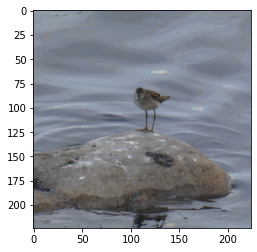

In [32]:
'P1060370'
predict(z, 'P1060370', False)
predict(s, 'P1060370')


Original image predictions:
drake (97): 0.5606926679611206
dowitcher (142): 0.19614948332309723
bullfrog, Rana catesbeiana (30): 0.03155537322163582
bittern (133): 0.027382755652070045
American coot, marsh hen, mud hen, water hen, Fulica americana (137): 0.020601635798811913

Original image predictions:
red-backed sandpiper, dunlin, Erolia alpina (140): 0.3931248188018799
dowitcher (142): 0.2091899961233139
drake (97): 0.10933602601289749
ruddy turnstone, Arenaria interpres (139): 0.0680159479379654
redshank, Tringa totanus (141): 0.057472746819257736


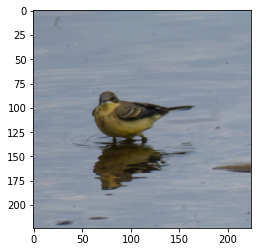

In [33]:
photo = 'P1060324'
predict(z, 'P1060324', False)
predict(s, 'P1060324')


Original image predictions:
kite (21): 0.49890217185020447
hummingbird (94): 0.14083366096019745
spoonbill (129): 0.05166799947619438
Arabian camel, dromedary, Camelus dromedarius (354): 0.025668956339359283
great grey owl, great gray owl, Strix nebulosa (24): 0.024502834305167198

Original image predictions:
kite (21): 0.856221616268158
hummingbird (94): 0.04861176013946533
great grey owl, great gray owl, Strix nebulosa (24): 0.04309507831931114
bulbul (16): 0.02513936534523964
dowitcher (142): 0.007036433555185795


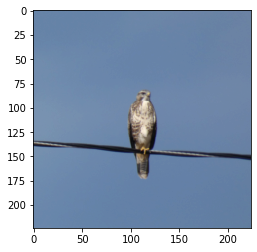

In [34]:
photo = 'P1060413'
predict(z, photo, False)
predict(s, photo)


Original image predictions:
howler monkey, howler (379): 0.06522365659475327
birdhouse (448): 0.03734221309423447
langur (374): 0.0276302769780159
colobus, colobus monkey (375): 0.02740084007382393
indri, indris, Indri indri, Indri brevicaudatus (384): 0.024405013769865036

Original image predictions:
indri, indris, Indri indri, Indri brevicaudatus (384): 0.24743615090847015
spider monkey, Ateles geoffroyi (381): 0.15585123002529144
howler monkey, howler (379): 0.11142636835575104
colobus, colobus monkey (375): 0.07414544373750687
langur (374): 0.054788265377283096


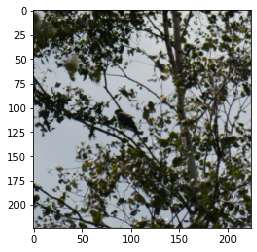

In [35]:
'P1060427'
photo = 'P1060427'
predict(z, photo, False)
predict(s, photo)


Original image predictions:
bald eagle, American eagle, Haliaeetus leucocephalus (22): 0.49911653995513916
bee eater (92): 0.2927485704421997
robin, American robin, Turdus migratorius (15): 0.04417339712381363
brambling, Fringilla montifringilla (10): 0.041722219437360764
hornbill (93): 0.03337595984339714

Original image predictions:
goldfinch, Carduelis carduelis (11): 0.5301536321640015
brambling, Fringilla montifringilla (10): 0.1615246683359146
house finch, linnet, Carpodacus mexicanus (12): 0.11578675359487534
bee eater (92): 0.06752274185419083
bulbul (16): 0.03747380152344704


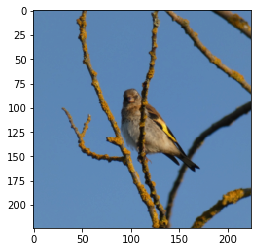

In [36]:
'P1060521'
photo = 'P1060521'
predict(z, photo, False)
predict(s, photo)